# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to predict the sale price of bulldozers.

## 1. Problem Definition

> How well can we predict the future sale price of a bulldozer, given its characterstics and previous examples of how much similiar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.

<!-- -->

* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

<!-- -->

* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.


## 3. Evaluation

The evaluation metric is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can download this file directly from the Kaggle competition page (account required): https://www.kaggle.com/account/login?returnUrl=%2Fcompetitions%2Fbluebook-for-bulldozers


First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

## Importing the data and preparing it for modelling

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from joblib import dump,load

Now we've got our tools for data analysis ready, we can import the data and start to explore it.

In [5]:
# Import training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False) 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

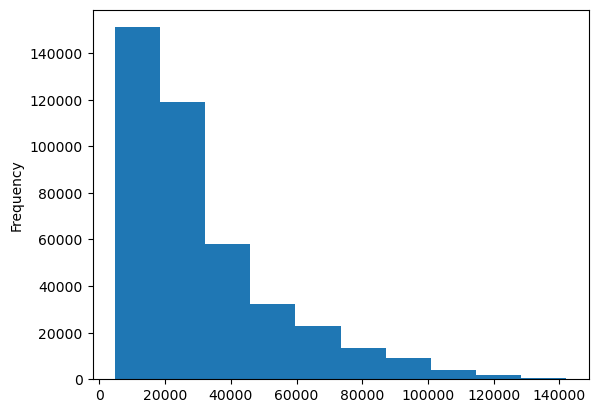

In [13]:
df.SalePrice.plot.hist();

We can see that most of our sale prices of bulldozers are at $20,000.

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible. 

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [50]:
# Import data again but this time parse data
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [51]:
df.saledate.dtype

dtype('<M8[ns]')

In [52]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

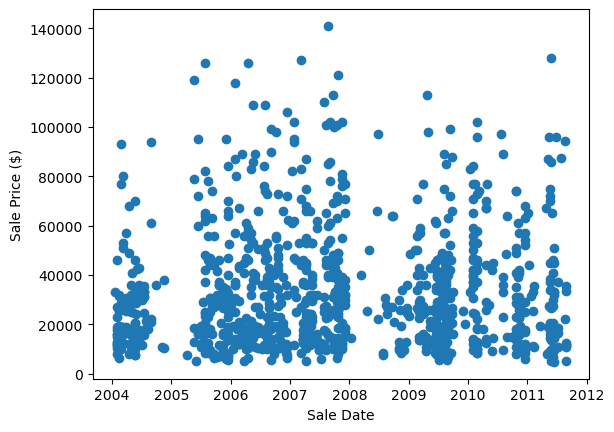

In [53]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

ax.set_xlabel("Sale Date");
ax.set_ylabel("Sale Price ($)");

In [54]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [55]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by sale date

When working with time series data, it's a good idea to sort it by date.

In [56]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dateframe so when we manipualte the copy, we've still got our original data.

In [57]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

### Add datetime parameters for `saledate` column

In [58]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [59]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [60]:
# Now we've enriched out DataFrame with data time features, we can remove 'saledate'
df_tmp.drop("saledate", axis=1, inplace=True)

In [63]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Turning Data into Numbers

In order to use a machine learning model, we first need to convert all strings to numbers and remove an NA values from the dataset.

### Convert string to categories

One way we can turn all of our data into number is by converting them into pandas categories.

We can check the different datatypes compatiabale with pandas here:
https://pandas.pydata.org/pandas-docs/version/1.4/reference/general_utility_functions.html

In [70]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [75]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [76]:
# This will turn all of the strings values into category values 
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [77]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [78]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [79]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [80]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas Categories, we now have a way to access all our data in the form of numbers.

But we still have a bunch of missing data we need to deal with.

### Save preprocessed data


In [82]:
# Export current tmp dataframe
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv",
              index=False)

In [84]:
# Import preprocessed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv",
                     low_memory=False)

df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


### Fill missing values

### Fill numerical missing values first

We'll first see which numeric columns have missing values.

In [87]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [89]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [90]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [92]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Nothing outputed which tells us that there are no more null numeric values.

In [95]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

Let's see if there are any missing values in other features besides numeric values.

In [96]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorical variables into numbers

Let's go check for columns which aren't numeric.

In [98]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [99]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1 to make all our numbers positive in our data frame
        df_tmp[label] = pd.Categorical(content).codes + 1

In [100]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [101]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


Let's check one more time that there are no missing values in our data set

In [102]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

### Save preprocessed data again


Export current tmp dataframe after our data is numeric and there are no more null values.

In [103]:
# Export current tmp dataframe
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp_processed.csv",
              index=False)

In [2]:
# Import preprocessed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp_processed.csv",
                     low_memory=False)

Now, we are ready to create a machine learning model after pre-processing our data.

## 6. Modelling

We've done enough exploratory data analysis (EDA) but let's start to do some model-driven EDA.

Now that all of our data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model. We will also time the model to see how long it will take to find all the patterns in all 412,698 rows.

In [109]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

CPU times: total: 17min 34s
Wall time: 3min 33s


RandomForestRegressor(n_jobs=-1, random_state=42)

Save model so we don't have retrain since there is a ton of data.

In [115]:
# Save the model
dump(model, "RandomForestRegressor.joblib")

['RandomForestRegressor.joblib']

In [5]:
# Load the model
model = load("RandomForestRegressor.joblib")

In [6]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.9875468079970562

**Question:** Why isn't the above metric reliable?

We have tested the model on the training data it just saw, so we need to split our data up into train/validation sets

### Splitting data into train/validation sets

In [9]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

Now we have a validation sets which contains 11,573 rows and a training dataset which contains 401,125 rows.

In [145]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

We split our data into train and validation sets and check to make sure the dimensions of each set match up.

### Building an evaluation function

In [31]:
# Create evaluation function for RMSLE (root-mean-squared-log-error)
def rmsle(y_test, y_preds):
    """
    Calculates root-mean-squared-log-error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different metrics
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Train MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}

    return scores

## Testing our model on a subset (to tune the hyperparameters)

We are going to train our model on a subset of the data so experimentation does not take as long since there are over 400,000 samples.

In [27]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [28]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: total: 36.8 s
Wall time: 7.41 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [32]:
show_scores(model)

{'Train MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

After evaluating our model we can see how well it has performed in each metric. Our valid score are lower than the training data so we did not overfit the data. Since we did only limit the training to 10,000 samples the scores are going to be worse.

However before we try training on the full dataset, let's see if we can tune this model to get better results.

### Hyperparameter tuning with RandomizedSearchCV

We will now tune our model with different parameters.

In [53]:
%%time

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20,2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                             param_distributions=rf_grid,
                             n_iter=5,
                             cv=5,
                             verbose=True,
                             random_state=42)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 20.7 s
Wall time: 38.1 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   random_state=42, verbose=True)

After fitting the RandomizedSearchCV model, let's see which parameters were the best.

In [54]:
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 1,
 'max_depth': None}

Now we'll evalute the model with our current parameters.

In [55]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Train MAE': 8891.655193695899,
 'Valid MAE': 11313.549827603978,
 'Training RMSLE': 0.39237058829152377,
 'Valid RMSLE': 0.4484052255971633,
 'Training R^2': 0.6825547447927643,
 'Valid R^2': 0.6361784117343763}

Our scores have actually gone down after tuning, but that just means we may need to try more iterations of finding better parameters.

Before:

* Train MAE: 5561.2988092240585
* Valid MAE: 7177.26365505919
* Training RMSLE: 0.257745378256977
* Valid RMSLE: 0.29362638671089003
* Training R^2: 0.8606658995199189
* Valid R^2: 0.8320374995090507

After:

* Train MAE: 8891.655193695899
* Valid MAE: 11313.549827603978
* Training RMSLE: 0.39237058829152377
* Valid RMSLE: 0.4484052255971633
* Training R^2: 0.6825547447927643
* Valid R^2: 0.6361784117343763

### Train a model with the best hyperparameters

**Note:** These were found after 100 iterations of RandomizedSearchCV

In [52]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: total: 2min 58s
Wall time: 36.8 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

Now let's see how well the model performs when we try this on all our training data.

In [57]:
# Scores for the ideal model on all the data
show_scores(ideal_model)

{'Train MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.2452416398953833,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

Before:

* Train MAE: 8891.655193695899
* Valid MAE: 11313.549827603978
* Training RMSLE: 0.39237058829152377
* Valid RMSLE: 0.4484052255971633
* Training R^2: 0.6825547447927643
* Valid R^2: 0.6361784117343763

After:

* Train MAE: 2953.8161137163484
* Valid MAE: 5951.247761444453
* Training RMSLE: 0.14469006962371858
* Valid RMSLE: 0.24524163989538328
* Training R^2: 0.9588145522577225
* Valid R^2: 0.8818019502450094

The model has scored much higher than the last experiment in all metrics.

## Make predictions on test data

We'll first need to import our test data

In [122]:
# Import test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


Before we can make predictions on the test data, we need to preprocess it first.

### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [123]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """

    # Add datetime parameters for saledate column
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    # Drop saledate column
    df.drop("saledate", axis=1, inplace=True)
    
    for label, content in df.items():
        # Find the columns which contain strings and turn them into categories
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()
            
        # Fill numeric rows with the median
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
        
        # Turn categorical variables into numbers and fill missing
        if not pd.api.types.is_numeric_dtype(content):
            # Add binary column to indicate whether sample had missing value
            df[label+"_is_missing"] = pd.isnull(content)
            # Turn categories into numbers and add +1 to make all our numbers positive in our data frame
            df[label] = pd.Categorical(content).codes + 1
        
    return df

Now we'll try processing our test data.

In [124]:
# Process the test data
df_test = preprocess_data(df_test)

In [146]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


There is still a problem. The test data is slightly different than the training data so we need to see which columns are different.

In [147]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

set()

We'll manually adjust the test data so it has an `auctioneerID_is_missing` column and just to be safe we'll make sure `df_test` has all the columns from the test data.

In [148]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [153]:
# Add test data columns
df_test = df_test[X_train.columns]
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


Finally, our test dataframe has the same features as our training dataframe, we can make predictions.

In [152]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [155]:
len(test_preds)

12457

We'll now format our predictions our model has made.

In [159]:
# Format predictions
df_preds = pd.DataFrame()
df_preds["SaleID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SaleID,SalePrice
0,1227829,17030.009274
1,1227844,14355.535652
2,1227847,46623.087743
3,1227848,71680.261335
4,1227863,61762.999424
...,...,...
12452,6643171,39966.363007
12453,6643173,12049.704433
12454,6643184,11964.850733
12455,6643186,16496.710793


Let's export our prediction data.

In [160]:
# Export prediction data
df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv", index=False)

Finally, let's wrap up this project by looking at the important features.

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the **target variable** (SalePrice).

In [164]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

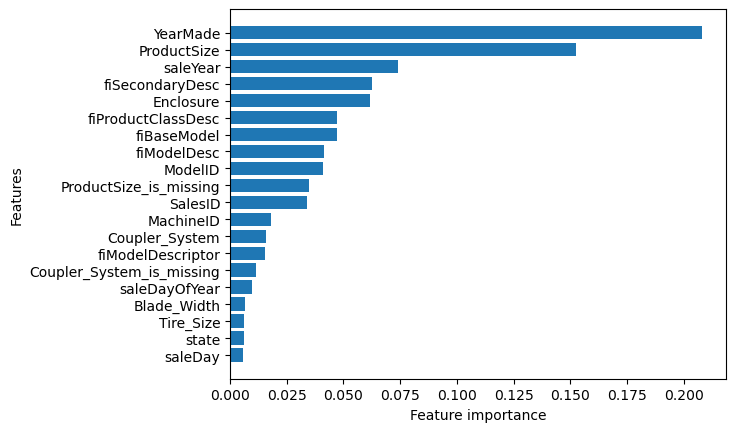

In [165]:
plot_features(X_train.columns, ideal_model.feature_importances_)

From the graph, `YearMade` and `ProductSize` seem to have the most correlation with the `SalePrice` which is our target variable.

## Conclusion

Overall, our model was able to perform well in all the metrics we evaluated. We'll look over the scores one last time:

* `Train MAE: 2953.8161137163484`
* `Valid MAE: 5951.247761444453`
* `Training RMSLE: 0.14469006962371858`
* `Valid RMSLE: 0.24524163989538328`
* `Training R^2: 0.9588145522577225`
* `Valid R^2: 0.8818019502450094`

In the future, I may try more tuning or use another machine learning model but nevertheless, I am satisfied with these results.